In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"]=42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection, LineCollection

import numpy as np
import pandas as pd
import time

import sys
# sys.path.append tells Jupyter where you saved the baltic3 folder
# un-comment out the next line to allow it to be run
#sys.path.append("path/to/baltic3/folder")

import baltic3 as bt
import baltic3_utils as btu

from treetime import TreeTime
from treetime.utils import parse_dates
import treetime.config as ttconf

In [5]:
# read tree
tre = btu.austechia_read_tree("sample-gis-aus-h3n2-treetime.tre", date_bool=True, date_delim="|")


Tree height: 13.487890
Tree length: 689.221930
annotations present

Numbers of objects in tree: 1018 (387 nodes and 631 leaves)

Highest tip date: 2018.8849


In [7]:
# Wrestling with treetime output
# I hope that the first element in the list is always the root
nd = tre.nodes[0]

yr0 = int(nd.traits["date"])
yr_max = 2019

# Skyline computations
# recomputes the timetree from the original dataset, which includes duplicate sequences
# ETA ~35mins for this setup
t0 = time.time()

meta_fn = '../data/gis-h3n2-aus-cdh-c1-dates.csv'
aln_fn = '../data/gis-h3n2-aus-cdh-c1.fas'
tre_fn = '../data/gis-h3n2-aus-cdh-c1-ft.nwk'

dates = parse_dates(meta_fn)
ebola = TreeTime(gtr='Jukes-Cantor', 
                 tree=tre_fn, precision=1,
                 aln=aln_fn, 
                 verbose=1, 
                 dates=dates)

# infer an ebola time tree
res = ebola.run(root='best', 
                infer_gtr=False, 
                relaxed_clock=False, 
                max_iter=2,
                branch_length_mode='input', n_iqd=3, resolve_polytomies=True,
                Tc='skyline', time_marginal="assign", vary_rate=True)

print("Done in %.2fs" % (time.time() - t0))


Attempting to parse dates...
	Using column 'name' as name. This needs match the taxon names in the tree!!
	Using column 'cdate' as date.

22.24	###TreeTime.run: INITIAL ROUND

72.14	###TreeTime.run: ITERATION 1 out of 2 iterations

242.45	###TreeTime.run: ITERATION 2 out of 2 iterations

1313.83	###TreeTime.run: FINAL ROUND - confidence estimation via marginal reconstruction


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/treetime/distribution.py:270: RuntimeWarning: overflow encountered in exp
  return np.exp(-1 * self.__call__(x))



2022.64	TreeTime: The following tips don't fit the clock model, please remove them from the tree. Their dates have been reset:

2022.64	A/Sydney/103/2017|EPI_ISL_274988|2017-03-29, input date: 2017.2409308692677, apparent date: 2018.19
Done in 2023.20s


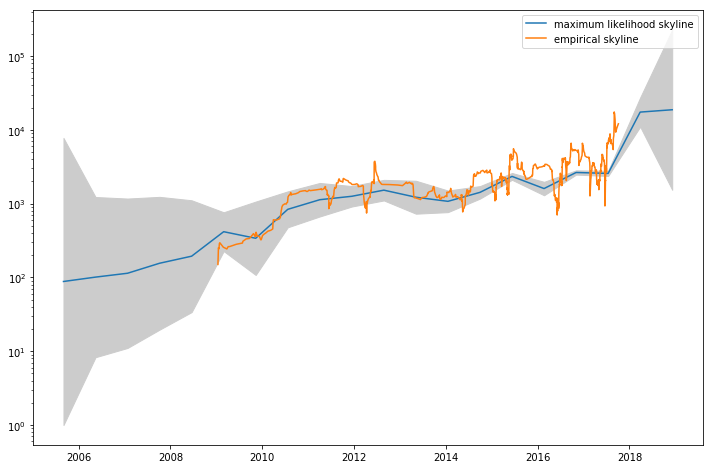

In [8]:
# reset branch length to time (in substitution rate units)
for n in ebola.tree.find_clades():
    n.branch_length=n.clock_length

# plot Skyline
skyline, confidence = ebola.merger_model.skyline_inferred(gen=50, confidence=2.0)
skyline_empirical = ebola.merger_model.skyline_empirical(gen=50)

plt.figure(figsize=(12, 8))
plt.fill_between(skyline.x, confidence[0], confidence[1], color=(0.8, 0.8, 0.8))
plt.plot(skyline.x, skyline.y, label='maximum likelihood skyline')
plt.plot(skyline_empirical.x, skyline_empirical.y, label='empirical skyline')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis='x',useOffset=False)

In [16]:
import pickle
fileobject = open("skyline-c1", 'wb')
pickle.dump(skyline, fileobject)
fileobject.close()

fileobject = open("skyline-confidence-c1", 'wb')
pickle.dump(confidence, fileobject)
fileobject.close()

fileobject = open("skyline-empirical-c1", 'wb')
pickle.dump(skyline_empirical, fileobject)
fileobject.close()

In [ ]:
# =================================== PARAMS ===================================
# LAYOUT
fig_h = 17 # figure height
fig_w = 24 # figure width
# Note: A4 proportions are 210 x 297 mm. 
# Set according to these proportions, scaling up or down as required.

# TREE PARAMS
branchWidth=0.5 # line thickness of branches
s=1 # tip shape size. 
x_offset= 0.00001
#It may be necessary to push the tree to the left to make room for the legend
#Otherwise, set this to an arbitrarily small number

# TIPNAMES & C/N LINES
tipname_x = tre.treeHeight * 1.02
tipname_fontsize = 4

# TEXT PARAMS
title_text = "A/H3N2 in Australia (2000 - 2019)"
title_text_size = 20
title_x = 0.0001
title_y = 4
tipname_x_offset = 0.01
tipname_fontsize = 12


In [ ]:
fig, (ax, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]}, 
                      figsize=(fig_w, fig_h),
                      facecolor='w')
br_lines = []
for k in tre.Objects:
    c = 'k'
    x=k.absoluteTime
    y=k.y

    xp = k.parent.absoluteTime
    if x is None: # matplotlib won't plot Nones, like root
        x = x_offset
    if xp==None:
        xp = x + x_offset

    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        pass

    elif isinstance(k,bt.node) or k.branchType=='node':
        line = np.array([[x, k.children[0].y], [x, k.children[-1].y]])
        br_lines.append(line)

    # Draw horizontal lines
    line = np.array([[xp, y], [x, y]])
    br_lines.append(line)

# Add title
#ax.text(title_x, title_y, title_text, fontsize=title_text_size)

# Draw background rectangles
background_patches = []
yr_rng = np.arange(yr0, yr_max, 2)
for yr in yr_rng:
    rect = mpatches.Rectangle(xy=(yr, -0.1*tre.ySpan), width=1.0, height=1000)
    background_patches.append(rect)
    ax.text(x=int(yr)+0.5, y=-0.1*tre.ySpan, 
            s="'"+str(yr)[-2:],
            fontsize=60, 
            color="k", 
            horizontalalignment="center")
    
ax.add_collection(PatchCollection(background_patches, facecolors='grey', alpha=0.12))
# Render branch lines
ax.add_collection(LineCollection(br_lines, color="k", linewidth=branchWidth))

ax.set_ylim([-0.1*tre.ySpan, tre.ySpan])
ax.set_xlim([yr0, yr_max])

# Skyline plot
ax2.fill_between(skyline.x, confidence[0], confidence[1], color=(0.8, 0.8, 0.8))
ax2.plot(skyline.x, skyline.y, label='maximum likelihood skyline')
ax2.plot(skyline_empirical.x, skyline_empirical.y, label='empirical skyline')
ax2.set_yscale('log')


# remove tick marks and borders
#ax.set_yticks([])
#ax.set_xticks([])
#plt.axis('off')

plt.tight_layout()

# Saves the figure to a png. pdf option also available. 
#plt.savefig("../assets/h3n2-c9975.png", bbox_inches="tight")

plt.show()